# Bayesian Optimization

## Introduction
 Bayesian optimization is a powerful approach for optimizing time-demanding objective functions. It operates by constructing a surrogate model, typically employing Gaussian process regression, to approximate the true objective function. This surrogate model not only provides predictions of the objective function but also quantifies the uncertainty associated with those predictions.

The central idea of Bayesian optimization is to iteratively select new points for evaluation based on an acquisition function, which is derived from the surrogate model. The acquisition function balances the exploration of uncertain regions in the search space with the exploitation of promising areas where the objective function is likely to be optimal.

By iteratively updating the surrogate model based on the observed evaluations and selecting new points for evaluation using the acquisition function, Bayesian optimization efficiently explores the search space and converges to the optimal solution while minimizing the number of costly evaluations of the objective function. This makes it particularly well-suited for optimizing black-box functions under constraints such as limited evaluation budget and lack of derivative information.

## Problem definition
We focus on solving the problem:

$$max_{x∈\mathcal{X}} f (x),
$$

where the feasible set and objective function typically have the following properties:


- Dimensionality: $ x \in \mathbb{R}^d $, typically with $ d \leq 20 $.
- Continuity: The objective function $ f $ is continuous, which is necessary for modeling $ f $ using Gaussian process regression.
- Expensive Evaluation: $ f $ is "expensive to evaluate", meaning the number of evaluations is limited, typically to a few hundred. This limitation arises due to time, cost (monetary or opportunity), or other resource constraints.
- Lack of Special Structure: $ f $ lacks known special structure like concavity or linearity, making it challenging to optimize efficiently using techniques leveraging such structure. It is termed a "black box" function.
- Derivative-Free: Observations of $ f(x) $ are made without access to first- or second-order derivatives, preventing the application of first- and second-order methods like gradient descent, Newton’s method, or quasi-Newton methods. This is referred to as "derivative-free" optimization.
- Noise-Free Observations: Observations of $ f(x) $ are made without noise.


In [90]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import os
import imageio 
from IPython.display import display, Image
np.random.seed(42)

## Blackbox function 

In [2]:
class BlackBox:
    def __init__(self):
        
        # grid lenght
        self.n = 50
        self.n2 = 100
        
        #Branin
        self.a = 1.0
        self.b = 5.1 / (4.0 * (np.pi ** 2))
        self.c = 5.0 / np.pi
        self.r = 6.0
        self.s = 10.0
        self.t = 1 / (8.0 * np.pi)
        
        #hartman 3d
        self.alpha = [1.0, 1.2, 3.0, 3.2]
        
        self.P = 10**(-4) * np.array([[3689, 1170, 2673],
                 [4699, 4387, 7470],
                 [1091, 8732, 5547],
                 [381, 5743, 8828]])
        
        self.A = np.array([[3.0, 10, 30],
                 [0.1, 10, 35],
                 [3.0, 10, 30],
                 [0.1, 10, 35]])

        
    @staticmethod        
    def simple_func(x:np.ndarray)-> np.ndarray:
        y = np.sin(x) + np.cos(2*x)
        return y


    @staticmethod
    def branin(x1: np.ndarray, x2: np.ndarray, a: float, b: float, c: float, r: float, s: float, t: float) -> np.ndarray:
        Hb = np.zeros_like(x1, dtype=float)
        Hb = a * (x2 - b * (x1 ** 2) + c * x1 - r) ** 2 + s * (1 - t) * np.cos(x1) + s
        return Hb


    @staticmethod
    def compute_y_values(xx: np.ndarray, alpha, A, P)-> np.ndarray:
        '''
        input: 
            xx = c(x1, x2, x3)
        
        parameters:
            self.alpha
            self.P
            self.A
        '''
        outer = 0
        for ii in range(4):
            inner = 0
            for jj in range(3):
                xj = xx[jj]
                Aij = A[ii, jj]
                Pij = P[ii, jj]
                inner += Aij * (xj - Pij) ** 2
            new = alpha[ii] * np.exp(-inner)
            outer += new
        y = -outer
        return y
    
    @classmethod
    def hartmann3d(cls,x1: np.ndarray, x2: np.ndarray,x3: np.ndarray, n, alpha, A, P):
        y_values = np.zeros((n, n, n))
        for i, x1_val in enumerate(x1):
            for j, x2_val in enumerate(x2):
                for k, x3_val in enumerate(x3):
                    y = cls.compute_y_values([x1_val, x2_val, x3_val], alpha, A, P)
                    y_values[i, j, k] = y
        return y_values
    
    

In [3]:
my_blackbox = BlackBox()
n = my_blackbox.n
n2 = my_blackbox.n2

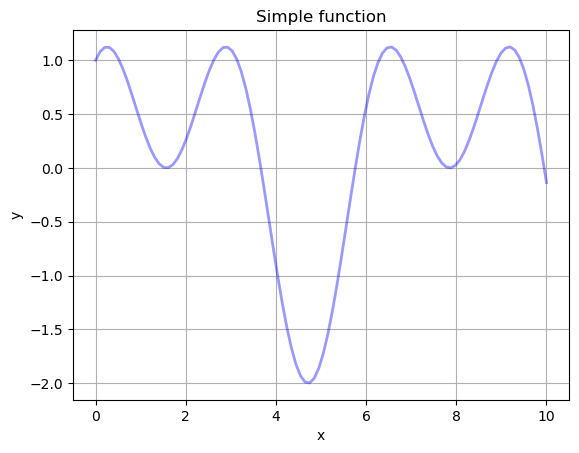

In [4]:
# Using the simple function
simple_f = my_blackbox.simple_func(np.linspace(0,10,n2))

plt.plot(np.linspace(0,10,n2), simple_f, linewidth=2, color='blue', alpha=0.4)
plt.title('Simple function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [5]:
# Using the branin function
x1 = np.array([0.1, 0.2, 0.3])
x2 = np.array([0.4, 0.5, 0.6])
result = my_blackbox.branin(x1, x2, my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)
print("Branin function result:", result)

Branin function result: [49.17099613 46.31420034 43.51920102]


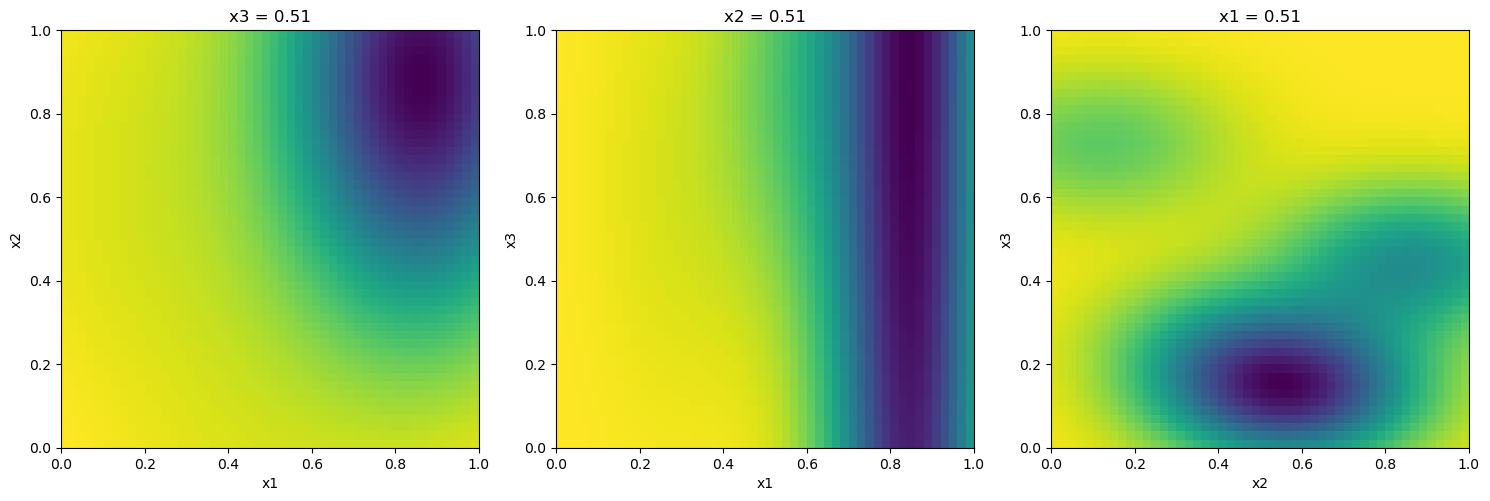

In [6]:
# Using the Hartmann function

x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
x3 = np.linspace(0, 1, n)

xx = np.array(np.meshgrid(x1, x2, x3)).T.reshape(-1, 3)

y_values = my_blackbox.hartmann3d(x1,x2,x3, my_blackbox.n, my_blackbox.alpha, my_blackbox.A, my_blackbox.P)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    if i == 0:
        ax.imshow(y_values[:, :, n // 2], extent=[x1.min(), x1.max(), x2.min(), x2.max()])
        ax.set_title('x3 = {:.2f}'.format(x3[n // 2]))
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
    elif i == 1:
        ax.imshow(y_values[:, n // 2, :], extent=[x1.min(), x1.max(), x3.min(), x3.max()])
        ax.set_title('x2 = {:.2f}'.format(x2[n // 2]))
        ax.set_xlabel('x1')
        ax.set_ylabel('x3')
    else:
        ax.imshow(y_values[n // 2, :, :].T, extent=[x2.min(), x2.max(), x3.min(), x3.max()])
        ax.set_title('x1 = {:.2f}'.format(x1[n // 2]))
        ax.set_xlabel('x2')
        ax.set_ylabel('x3')

plt.tight_layout()
plt.show()

## Branin function 

In [7]:
x1,x2 = np.meshgrid( np.linspace(-5, 10, n, dtype=float),
                     np.linspace(0, 15, n, dtype=float)) # grid of points

y = my_blackbox.branin(x1, x2, my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)


In [8]:
matriX=np.column_stack((x1.ravel(),x2.ravel()))

In [9]:
# Create a plotly interactive graph
fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=y, colorscale='viridis')]) # type: ignore

fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis'),
                    yaxis=dict(title='Y Axis'),
                    zaxis=dict(title='Z Axis')),
                    title='Branin function 3D Plot',
                    autosize=False,
                    width=800,
                    height=600,
                    margin=dict(l=65, r=50, b=65, t=90))

# Display the plot
fig.show()

## Initial Sample

In [10]:
def sampling(x1: np.ndarray, x2: np.ndarray, n_sample: int, a: float, b: float, c: float, r: float, s: float, t: float )-> tuple[np.ndarray, np.ndarray]:
    """_summary_

    Args:
        x1 (np.ndarray): _description_
        x2 (np.ndarray): _description_
        n_sample (int): _description_
        a (float): _description_
        b (float): _description_
        c (float): _description_
        r (float): _description_
        s (float): _description_
        t (float): _description_

    Returns:
        tuple[np.ndarray, np.ndarray]: _description_
    """
    s_x = np.zeros((n_sample,2), dtype=float)
    s_x[:,0] = np.random.choice(x1[0,:], n_sample)
    s_x[:,1] = np.random.choice(x2[:,0], n_sample)
    
    s_z = np.zeros_like(s_x, dtype=float)
    s_z = my_blackbox.branin(s_x[:,0], s_x[:,1], a=a, b=b, c=c, r=r, s=s, t=t)

    return s_x, s_z


In [11]:
n_sample = 10
sample_x, sample_y = sampling(x1, x2, n_sample, my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)
reference=sample_x[:,1].min()#Reference point sampled for the plot in 1D

In [12]:
sample_x

array([[ 6.63265306,  3.06122449],
       [ 3.57142857,  7.04081633],
       [-0.71428571, 10.71428571],
       [ 7.85714286, 11.93877551],
       [-2.85714286,  7.04081633],
       [ 1.12244898,  0.6122449 ],
       [ 6.63265306,  6.42857143],
       [ 0.51020408,  0.30612245],
       [ 1.73469388,  7.04081633],
       [-1.93877551, 13.16326531]])

## Gaussian process

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Gaussian process regressor with a Matern kernel
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
gp_model = GaussianProcessRegressor(kernel=kernel) #Add manually the optimizer defining a function, if nothing is written params are kept constant

IDEA ON HOW TO IMPLEMENT THE OPTIMIZER (taken from documentation of sklearn GaussianProcessRegressor)

In [69]:
def optimizer(obj_func, initial_theta, bounds):
    # * 'obj_func': the objective function to be minimized, which
    #   takes the hyperparameters theta as a parameter and an
    #   optional flag eval_gradient, which determines if the
    #   gradient is returned additionally to the function value
    # * 'initial_theta': the initial value for theta, which can be
    #   used by local optimizers
    # * 'bounds': the bounds on the values of theta
    ...
    # Returned are the best found hyperparameters theta and
    # the corresponding value of the target function.
    return theta_opt, func_min

In [14]:
# Fit the Gaussian process model to the sampled points
gp_model.fit(sample_x, sample_y)

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5))

In [15]:
# Generate predictions using the Gaussian process model
y_pred, y_std = gp_model.predict(matriX, return_std=True)

Cut the surface at y=min value to make the plot in 2D

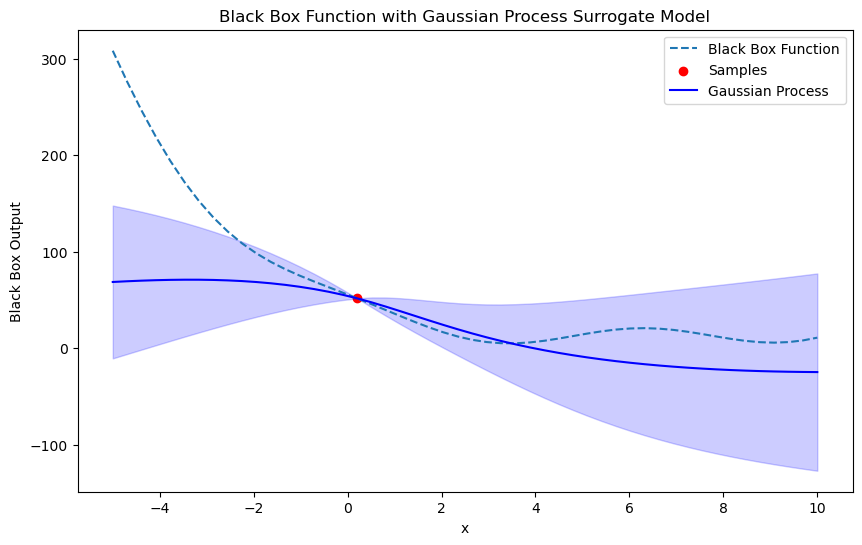

In [42]:
# Plot 
plt.figure(figsize=(10, 6))

plt.plot(matriX[matriX[:,1]==reference][:,0], y[np.where(x2==reference)],linestyle='--', label='Black Box Function')

plt.scatter(sample_x[sample_x[:,1]==reference][:,0], sample_y[np.where(sample_x[:,1]==reference)], color='red', label='Samples')

plt.plot(matriX[matriX[:,1]==reference][:,0], 
         y_pred[np.where(matriX[:,1]==reference)], color='blue', label='Gaussian Process')

plt.fill_between(matriX[matriX[:,1]==reference][:,0],
                  y_pred[np.where(matriX[:,1]==reference)] - 2*y_std[np.where(matriX[:,1]==reference)], 
                  y_pred[np.where(matriX[:,1]==reference)] + 2*y_std[np.where(matriX[:,1]==reference)], color='blue', alpha=0.2)

plt.xlabel('x')

plt.ylabel('Black Box Output')

plt.title('Black Box Function with Gaussian Process Surrogate Model')

plt.legend()

plt.show()

In [53]:
y_pred.shape

(2500,)

In [16]:
def plot_3d_surface_variance(x1, x2, y_values, y_std):
    y_values_reshaped = y_values.reshape(x1.shape)
    y_std_reshaped = y_std.reshape(x1.shape)

    fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=y_values_reshaped, colorscale='Viridis', name='ypred')])

    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped + y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='ypred + y_std'))
    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped - y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='ypred - y_std'))

    # Set layout
    fig.update_layout(scene=dict(
                        xaxis_title='X1',
                        yaxis_title='X2',
                        zaxis_title='Acquisition function'))
    
    # Show plot
    fig.show()
    
plot_3d_surface_variance(x1, x2, y_pred,y_std)


# Acquisition function

In this section we explain the precise process or strategy for choosing the order of query points $x_{1:n}$. While random selection is an option, it's inefficient. Instead, various strategies in literature use the posterior model to guide the sequential search, determining the next query point $x_{n+1}$ based on $\mathcal{D}_n=\{(x_1,y_1),...,(x_n,y_n)\}$.

Acquisition functions are designed to balance between exploring new areas of the search space and exploiting the current promising areas.

Once an acquisition function is employed to identify the next hyperparameter, the actual score of this new hyperparameter based on the true objective function is acquired. Because the surrogate model has been trained on pairs of (hyperparameter, true objective function score), incorporating a new data point updates the surrogate model.

In the following we will consider x, the query point, its corresponding function value $\nu = f(x)$ and the model hyperparameters $\theta$. UTILITY FUNCTION?. We can marginalize the unseen outcome y and the unknown model hyperparameters $\theta$ ...  SPIEGARE?

#### PI acquisition function
Probability of improvement acquisition function is an improvement-based acquisition function, meaning that it favors points that are likely to improve upon a certain time.
This function measures the probability that a point x leads to an improvement upon $\tau$. We can analytically compute this probability as follows:
$$
\alpha_{PI}(x;\mathcal{D}_n) := \mathcal{P}[\nu > \tau] = \Phi\left(\frac{\mu_n(x) - \tau}{\sigma_n(x)}\right)
$$

where $\Phi$ is the standard normal cumulative distribution function. As we can see from the formula PI considers the difference between the mean prediction and the current best value, taking into account the uncertainty in the surrogate model. $\alpha_{PI}(x;\mathcal{D}_n)$ is then maximized to select the next query point.

#### EI acquisition function
PI is often a good solution for the choice of the acquisition function when the target is known; in general, however the heuristic used for an unknown target causes PI to exploit quite aggressively.    
We can consider a differen acquisition function (EI).    
This new criterion corresponds to a different utility function,the improvement function, denoted by $I(x)$, which is defined as follows: 
$$I(\text{x}, \nu,\theta)=(\nu-\tau)\mathbb{I}(\nu>\tau)$$
and it has positive value only if there is an improvement. Since $\nu$ is normally distributed, the *expectation of improvement* can be computed as:
$$\alpha_{EI}(\text{x},\mathcal{D}_n)=\mathbb{E}[I(\text{x}, \nu,\theta)]=(\mu_n(\text{x}-\tau))\Phi \left(\dfrac{\mu_n(\text{x})-\tau}{\sigma_n(\text{x})}\right)  + \sigma_n(\text{x})\phi\left(\dfrac{\mu_n(\text{x})-\tau}{\sigma_n(\text{x})}\right) $$
when $\sigma_n>0$ (it vanishes otherwise); in this expression:
- $\Phi$ is the standard normal cumulative distribution function
- $\phi$ is the standard normal probability distribution function.    
    
    

>*Note on the parameter $\tau$*:
>although the target value (the best reachable objective value) is often unknown, in practice $\tau$ is adaptively set to be the best observed value ($\tau=y^+=max_{i=1:n}y_i$)


***This part below will need to be fixed dimensionally after we finish the implementation of the Gaussian Process model***

In [23]:
# Probability of improvement
def prob_i(x: np.ndarray, model: GaussianProcessRegressor, bst_z: np.ndarray)-> np.ndarray:
    """_summary_

    Args:
        x (_type_): _description_
        model (GaussianProcessRegressor): _description_
        bst_z (np.ndarray): _description_

    Returns:
        _type_: _description_
    """
    pred, std = model.predict(x, return_std=True)
    z = (pred - bst_z)/std
    pI = norm.cdf(z)
    return pI

In [24]:
# Expected improvement
def expected_i(x: np.ndarray, model: GaussianProcessRegressor, bst_z)-> np.ndarray:
    """_summary_

    Args:
        x: grid of points
        gp_model: gaussian process model
        bst_z: max value of y (tau)
    
    Returns: 
        expected improvement
    """
    

    #Compute mean and std of y
    pred, std = model.predict(x, return_std=True)
    
    #Compute ei
    z = (pred - bst_z) / std

    eI = (pred - bst_z) * norm.cdf(z) + std * norm.pdf(z)
    eI = np.array(eI,dtype=float)
    return eI

# Optimization/training

## 1. Likelihood optimization

In [54]:
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
gp_model = GaussianProcessRegressor(kernel=kernel, optimizer="fmin_l_bfgs_b")

In [55]:
x1,x2 = np.meshgrid( np.linspace(-5, 10, n, dtype=float),
                     np.linspace(0, 15, n, dtype=float)) # grid of points
matriX = np.column_stack((x1.ravel(),x2.ravel()))

In [79]:
n_sample = 10
sample_x, sample_y = sampling(x1, x2, n_sample, a, b, c, r, s, t)
reference=sample_x[:,1].min()#Reference point sampled for the plot in 1D

In [83]:
sample_x # 'sample fortunato'

array([[-1.93877551, 11.63265306],
       [ 3.26530612,  1.53061224],
       [ 2.34693878,  2.14285714],
       [ 6.63265306,  7.95918367],
       [ 4.79591837,  2.44897959],
       [-5.        , 11.02040816],
       [ 2.95918367,  9.79591837],
       [-1.32653061, 12.55102041],
       [ 7.24489796, 13.16326531],
       [-4.3877551 ,  7.04081633]])

In [63]:
n_iter = 10
x = sample_x
y = sample_y

poi = True
print('The best_y is: ')

for i in range(n_iter): 
    
    #Ottimizzare kernel:
    # kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    # gp_model = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    
    gp_model.fit(x,y)
    
    # Generate predictions using the Gaussian process model
    matrixx = np.column_stack((x[:,0].ravel(),x[:,1].ravel()))
    y_pred, y_std = gp_model.predict(matrixx, return_std=True)
    
    best_idx = np.argmax(y)
    best_x = x[best_idx]
    best_y = y[best_idx]
    print(best_y)
    
    if poi==True:
        improv = prob_i(matriX,gp_model,best_y)
    else:
        improv = expected_i(matriX,gp_model,best_y)
        
    if i < n_iter - 1:
        new_x = matriX[np.argmax(improv)].reshape(-1,2)  # Select the next point based on
        #new_y = branin(new_x[0,0],new_x[0,1],a, b, c, r, s, t)
        new_y = my_blackbox.branin(new_x[0,0],new_x[0,1], my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)
        x = np.concatenate((x, new_x))
        y = np.append(y, new_y)
    
print('fatto!')
    

The best_y is: 
145.78522203055712
176.4957320767277
210.7227500221526
248.36544996005588
257.85750286646805
267.53697768041866
277.40387440190796
287.4581930309356
297.69993356750194
308.12909601160663
fatto!


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [23]:
x

array([[ 6.63265306,  3.06122449],
       [ 3.57142857,  7.04081633],
       [-0.71428571, 10.71428571],
       [ 7.85714286, 11.93877551],
       [-2.85714286,  7.04081633],
       [ 1.12244898,  0.6122449 ],
       [ 6.63265306,  6.42857143],
       [ 0.51020408,  0.30612245],
       [ 1.73469388,  7.04081633],
       [-1.93877551, 13.16326531],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796],
       [ 8.16326531, 12.24489796]])

In [24]:
best_y

120.04075251515627

In [233]:
best_x

array([ 6.32653061, 15.        ])

## Plot 3d acquisition function

In [65]:
def plot_3d_surface(x1, x2, y_values):
    
    #x1,x2 = np.meshgrid( np.linspace(-5, 10, n, dtype=float),
    #                 np.linspace(0, 15, n, dtype=float)) # grid of points
    
    y_values_reshaped = y_values.reshape(x1.shape)

    # Create the Plotly surface plot
    fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=y_values_reshaped, colorscale='Viridis')])

    # Set layout
    fig.update_layout(scene=dict(
                        xaxis_title='X1',
                        yaxis_title='X2',
                        zaxis_title='Acquisition function'))
        # Show the plot
    fig.show()

In [66]:
plot_3d_surface(x1, x2, improv)

# Training con gif

In [82]:
from PIL import Image
import os
folder_path = '/home/gloria/Scrivania/Information theory and inference/info theory project/'
n_iter = 10
x = sample_x
y = sample_y

# Definisci la funzione per la rappresentazione della superficie 3D con varianza
def plot_3d_surface_variance(x1, x2, y_values, y_std,iteration_number, filename=None):
    y_values_reshaped = y_values.reshape(x1.shape)
    y_std_reshaped = y_std.reshape(x1.shape)

    fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=y_values_reshaped, colorscale='Viridis', name='Predicted Branin Function')])

    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped + y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='Predicted Branin Function + Std Dev'))
    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped - y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='Predicted Branin Function - Std Dev'))

    # Set layout
    fig.update_layout(scene=dict(
                        xaxis_title='X1',
                        yaxis_title='X2',
                        zaxis_title='Predicted Branin Function'),
                        title=f'Iteration {iteration_number}')

    # Save plot as image
    if filename:
        fig.write_image(filename)

frames = []

for i in range(n_iter):
    # Addestrare il modello Gaussian Process
    gp_model.fit(x, y)
    
    # Generare le predizioni utilizzando il modello Gaussian Process
    y_pred, y_std = gp_model.predict(matriX, return_std=True)
    
    # Creare il plot 3D della superficie con varianza e salvarlo come immagine temporanea
    filename = f"frame_{i}.png"
    plot_3d_surface_variance(x1, x2, y_pred, y_std,i, filename)
    
    # Aggiungere l'immagine alla lista dei frame
    frames.append(Image.open(filename))
    
    best_idx = np.argmax(y)
    best_x = x[best_idx]
    best_y = y[best_idx]
    
    if poi==True:
        improv = prob_i(matriX,gp_model,best_y)
    else:
        improv = expected_i(matriX,gp_model,best_y)
        
    if i < n_iter - 1:
        new_x = matriX[np.argmax(improv)].reshape(-1,2)  # Select the next point based on
        new_y = my_blackbox.branin(new_x[0,0],new_x[0,1], my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)
        x = np.concatenate((x, new_x))
        y = np.append(y, new_y)
        
# Creare la GIF utilizzando i frame salvati nella cartella specificata
gif_path = os.path.join(folder_path, 'gifs/branin_optimization.gif')
frames[0].save(gif_path, save_all=True, append_images=frames[1:], optimize=False, duration=200, loop=0)

# Rimuovere i frame salvati
for frame_file in os.listdir(folder_path):
    if frame_file.startswith('frame_') and frame_file.endswith('.png'):
        os.remove(os.path.join(folder_path, frame_file))


## 2. Sequential Monte Carlo

In [238]:
kernel = 1.0 * Matern(length_scale=[1.0,8], nu=1.5)

In [239]:
kernel.get_params()

{'k1': 1**2,
 'k2': Matern(length_scale=[1, 8], nu=1.5),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': [1.0, 8],
 'k2__length_scale_bounds': (1e-05, 100000.0),
 'k2__nu': 1.5}

In [240]:
kernel.n_dims

3

In [241]:
kernel.theta

array([0.        , 0.        , 2.07944154])

1**2 * Matern(length_scale=[1, 8], nu=1.5)

# A) Simple function

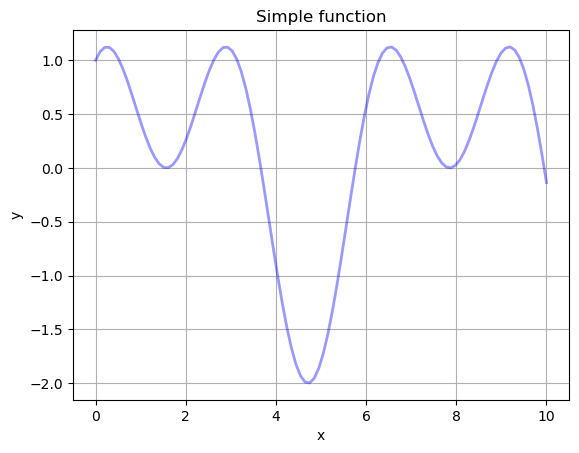

In [18]:
# Generate a grid and plot the simple function

x_grid = np.linspace(0,10,n2)
simple_f = my_blackbox.simple_func(x_grid)

plt.plot(np.linspace(0,10,n2), simple_f, linewidth=2, color='blue', alpha=0.4)
plt.title('Simple function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

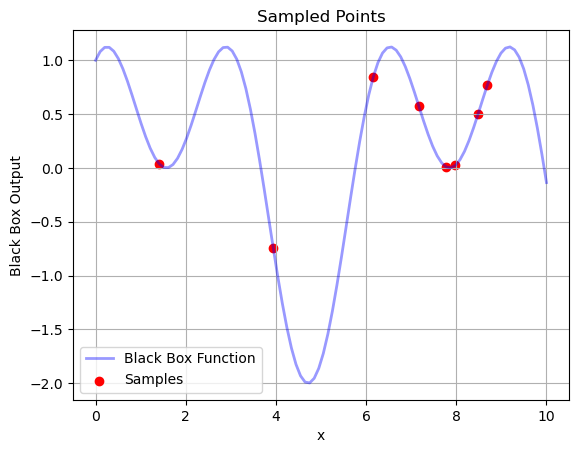

In [52]:
# Sample 5 outputs from function f
n_sample = 8
sample_x = np.random.choice(x_grid, n_sample)

# output for each sampled x value
sample_y =  my_blackbox.simple_func(sample_x)

# plot
plt.plot(x_grid, simple_f, label='Black Box Function',linewidth=2, color='blue', alpha=0.4)
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Sampled Points')
plt.legend()
plt.grid()
plt.show()


In [109]:
# Acquisition function
def prob_i(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    pi = norm.cdf(z)
    return pi

from scipy.stats import norm
def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

In [107]:
# Sample outputs from function f
n_sample = 15
sample_x = np.random.choice(x_grid, n_sample)

# output for each sampled x value
sample_y =  my_blackbox.simple_func(sample_x)

# Parameters
num_iterations = 15
folder_path = '/home/gloria/Scrivania/Information theory and inference/info theory project/'
frames = []
plt.figure(figsize=(10, 6))

# Determine the initial limits of the plot
y_min = min(sample_y)-1
y_max = max(sample_y)+1
x_min = min(sample_x)-1
x_max = max(sample_x)+1

# gaussian process
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
gp_model = GaussianProcessRegressor(kernel=kernel, optimizer="fmin_l_bfgs_b")

for i in range(num_iterations):
    
    # Fit the Gaussian process model to the sampled points
    gp_model.fit(sample_x.reshape(-1, 1), sample_y)

    # Determine the point with the highest observed function value
    best_idx = np.argmax(sample_y)
    best_x = sample_x[best_idx]
    best_y = sample_y[best_idx]
    print(best_y)

    # Generate the acquisition function using the Gaussian process model
    y_pred, y_std = gp_model.predict(x_grid.reshape(-1, 1), return_std=True)
    improv = prob_i(x_grid.reshape(-1, 1), gp_model, best_y)

    # Plot the black box function, surrogate function, previous points, and new points
    plt.plot(x_grid, my_blackbox.simple_func(x_grid), color='orange', label='Black Box Function',linewidth=2, alpha = 0.7)
    plt.plot(x_grid, 10*improv, color='red', linestyle='dashed', label='10 x Surrogate Function', alpha = 0.8)
    plt.fill_between(x_grid, y_pred - 2*y_std, y_pred + 2*y_std, color='blue',alpha=0.2)
    plt.plot(x_grid, y_pred, color='blue', label='Gaussian Process', alpha = 0.7, linewidth=2)
    plt.scatter(sample_x, sample_y, color='red', label='Previous Points')
    
    if i < num_iterations - 1:
        new_x = x_grid[np.argmax(improv)]  # Select the next point based on UCB
        new_y = my_blackbox.simple_func(new_x)
        sample_x = np.append(sample_x, new_x)
        sample_y = np.append(sample_y, new_y)
        plt.scatter(new_x, new_y, color='green', label='New Points')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Iteration #{i+1}")
    plt.legend()
    plt.grid()
    
    # Set the fixed limits for the plot
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Save frame 
    filename = f"frame_{i}.png"
    plt.savefig(os.path.join(folder_path, filename))
    frames.append(filename)
    plt.clf()  # Clear current figure
    
# Creare la GIF utilizzando i frame salvati nella cartella specificata
gif_path = os.path.join(folder_path, 'gifs/simple_optimization.gif')
with imageio.get_writer(gif_path, mode='I', duration=0.6) as writer:
    for frame in frames:
        image = imageio.imread(os.path.join(folder_path, frame))
        writer.append_data(image)

# Rimuovere i frame salvati
for frame_file in frames:
    os.remove(os.path.join(folder_path, frame_file))



1.0840238205253971
1.120312207077811


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



1.120312207077811
1.120312207077811


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



1.120312207077811
1.120312207077811


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



1.120312207077811
1.120312207077811


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



1.120312207077811
1.120312207077811


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



1.120312207077811
1.120312207077811


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



1.120312207077811
1.120312207077811


/home/gloria/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



1.120312207077811


/tmp/ipykernel_34803/610154736.py:73: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



<Figure size 1000x600 with 0 Axes>

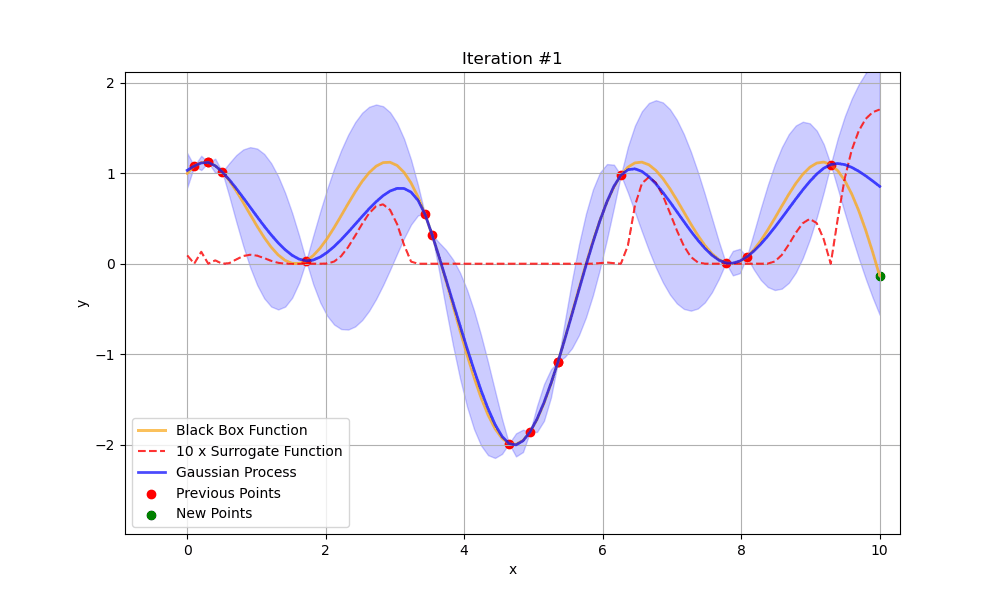

In [99]:
#display the evolution with expected improvment
gif_path = os.path.join(folder_path, 'gifs/simple_optimization.gif')
display(Image(filename=gif_path))


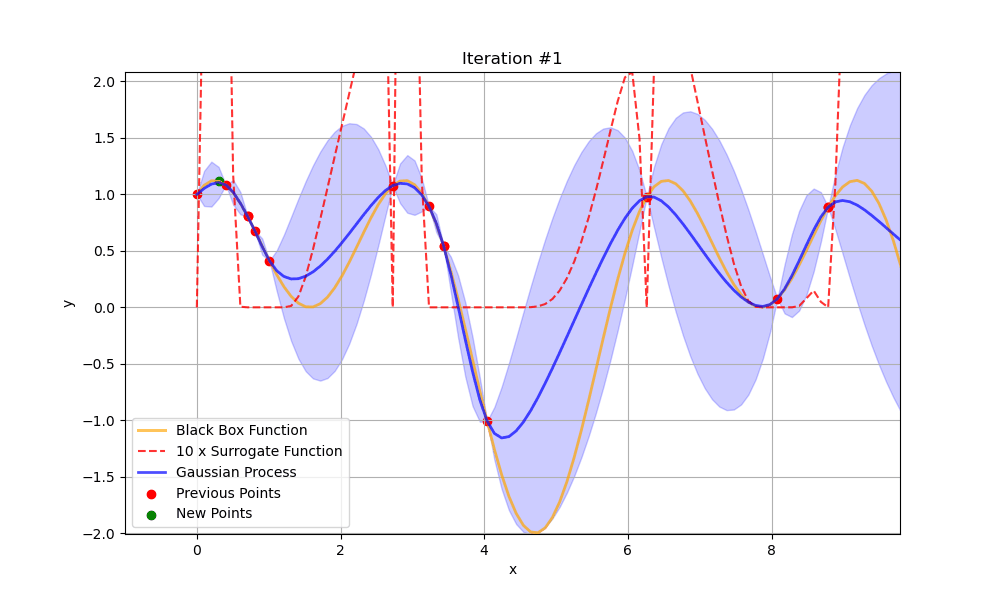

In [108]:
#display the evolution with pribability improvement
gif_path = os.path.join(folder_path, 'gifs/simple_optimization.gif')
display(Image(filename=gif_path))
